In [1]:
import misc.trs_refactor as trs
import numpy as np
import matplotlib_inline
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import zarr
import numcodecs
import json

In [2]:
# Specify the path to your JSON file (adjust as necessary)
path = "."  # Folder where "Metadata 00012.json" is located
name = "Metadata"
number = 12
ext = "json"

# Instantiate the Metadata object
metadata_instance = trs.Metadata(path, name, number, ext)

# Print out some details
print(f"CCD (nx, ny): ({metadata_instance.md_ccd_nx}, {metadata_instance.md_ccd_ny})")
print(f"Pass Energy: {metadata_instance.md_pass_energy}")
print(f"Center Energy: {metadata_instance.md_center_energy}")
print(f"Rectangle Coordinates: Left {metadata_instance.roi_l}, Top {metadata_instance.roi_t}, Right {metadata_instance.roi_r}, Bottom {metadata_instance.roi_b}")

# Print the entire metadata
print(metadata_instance)

CCD (nx, ny): (1392, 1040)
Pass Energy: 200
Center Energy: 1954
Rectangle Coordinates: Left 148, Top 385, Right 1279, Bottom 654
{
    "F_Trigger": 19,
    "F_Un-Trigger": 81,
    "F_Dead": 143,
    "F_Reset": 150,
    "CCD_nx": 1392,
    "CCD_ny": 1040,
    "Pass Energy": 200,
    "Center Energy": 1954,
    "Offset Energy": -0.837,
    "Lens Mode": "X6-26Mar2022-test",
    "Rectangle": {
        "Left": 148,
        "Top": 385,
        "Right": 1279,
        "Bottom": 654,
        "Rotation": 0
    },
    "Notes": "",
    "dt": 0.0820741786426572,
    "Photon Energy": 3999.99965566672,
    "Binding Energy": 90,
    "File Ver": "1.0.0",
    "Stream": "Full Frame (FF)"
}


In [3]:
""" Read a frame from a Frame Stream
MAKE sure you don't put a space after "Frame Stream" even so the filename is "Frame Stream " followed by the number
The number also to be 12 NOT 00012 like the filename """
    
frame_stream = trs.FrameStream(path=".", name="Frame Stream", number=12, ext="bin")
ccd_image, normalization = frame_stream.__frame_data__(frame_i=0)
print(ccd_image, normalization)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 4.894080810008295


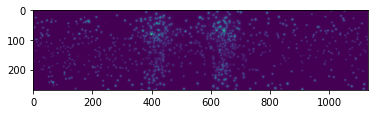

In [4]:
plt.imshow(ccd_image[385:654,148:1279])

In [5]:
""" Read the averaged spectrum from an ESpec Stream averaged over 
 "Rectangle": {
        "Left": 148,
        "Top": 385,
        "Right": 1279,
        "Bottom": 654,
        "Rotation": 0
    },
"""
espec_stream = trs.ESpecStream(path=".", name="ESpectrum Stream", number=12, ext="bin")


In [12]:
""" Extract the scan for frame_i = 0"""
espec_data, normalization = espec_stream.__espec_data__(frame_i=0)
print(espec_data, normalization)


[81 53 45 ... 51 47 48] 4.894080810008295


In [14]:
espec_data.shape[0]

1131

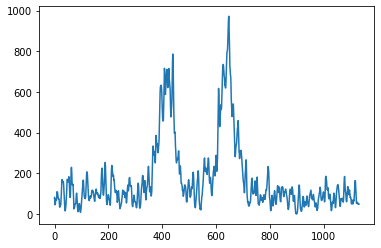

In [7]:
plt.plot(espec_data)

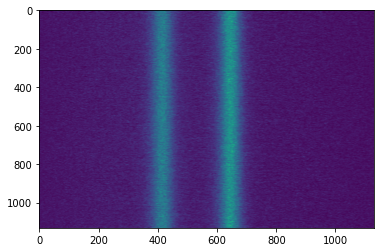

In [15]:

# Assuming espec_stream is your ESpecStream object initialized correctly
# And assuming total_line_scans represents the total number of frames

line_scans = []
for frame_i in range(int(espec_data.shape[0])):  # Ensure it's an integer
    espec_data, normalization = espec_stream.__espec_data__(frame_i)
    line_scans.append(espec_data)

# Convert the list of line scans into a 2D NumPy array
image_data = np.vstack(line_scans)  # Stack vertically

# If you need to transpose the image (depending on the orientation you need)
# image_data = image_data.T

# Proceed with visualization or saving as previously described
plt.imshow(image_data, aspect="auto")

In [113]:


# Assuming espec_stream.num_frames is corrected to be an integer
espec_data_list = []
for frame_i in range(int(espec_stream.num_frames)):
    frame_data, _ = espec_stream.__espec_data__(frame_i)
    espec_data_list.append(frame_data)

# Convert the list of arrays to a single NumPy array
espec_data = np.array(espec_data_list)

print('Number of frame: ' + str(int(frame_stream.num_frames)))
# Example dimensions, replace these with actual dimensions
n_frames = int(frame_stream.num_frames)  # Total number of frames
frame_height = frame_stream.n_y  # Height of a frame
frame_width = frame_stream.n_x  # Width of a frame

# Preallocate the array with zeros or another placeholder value
frame_data = np.zeros((frame_height, frame_width, n_frames), dtype=np.float32)  # Adjust dtype as needed
dummy = 1 
# Fill in the data for each frame
for frame_i in range(100): #range(n_frames): JUST writing 200 frame instead of all frames
    dummy += 1
    if dummy % 100 == 0:
        print(dummy)
    frame_image, _ = frame_stream.__frame_data__(frame_i)
    frame_data[:, :, frame_i] = frame_image

#Incase we have memory issues 
# frame_data = np.memmap('frame_data.dat', dtype=np.float32, mode='w+', shape=(frame_height, frame_width, n_frames))

# for frame_i in range(n_frames):
#     frame_image, _ = frame_stream.__frame_data__(frame_i)
#     frame_data[:, :, frame_i] = frame_image

# or  but this is even slower# Force num_frames to be an integer when using it
# num_frames_int = int(espec_stream.num_frames)
# for frame_i in range(num_frames_int):
#     frame_data, _ = espec_stream.__espec_data__(frame_i)
#     espec_data_list.append(frame_data)



# Create a Zarr group to store your datasets
root_group = zarr.open("./test.zarr", mode="w")

with open('./Metadata 00012.json', 'r') as f:
     metadata = json.load(f)

# Store the metadata as an attribute of the root group
root_group.attrs['metadata'] = metadata

# Specify a compressor, for example Zstandard with compression level 3
compressor = numcodecs.Zstd(level=3)

# Then use this compressor when creating datasets
root_group.create_dataset("espec_data", data=espec_data, chunks=True, compressor=compressor)
root_group.create_dataset("frame_data", data=frame_data, chunks=True, compressor=compressor)

Number of frame: 11400
100


<zarr.core.Array '/frame_data' (1040, 1392, 11400) float32>

In [118]:
# Open the Zarr file (or directory)
root_group = zarr.open('./test.zarr', mode='r')
# List all items (datasets and groups) at the root level
print(list(root_group.keys()))

# List all attributes of the root group
print(dict(root_group.attrs))
for name in root_group.keys():
    item = root_group[name]
    if isinstance(item, zarr.core.Array):
        print(f"Dataset '{name}' with shape {item.shape} and dtype {item.dtype}")
    elif isinstance(item, zarr.hierarchy.Group):
        print(f"Group '{name}' containing {list(item.keys())}")


['espec_data', 'frame_data']
{'metadata': {'Binding Energy': 90, 'CCD_nx': 1392, 'CCD_ny': 1040, 'Center Energy': 1954, 'F_Dead': 143, 'F_Reset': 150, 'F_Trigger': 19, 'F_Un-Trigger': 81, 'File Ver': '1.0.0', 'Lens Mode': 'X6-26Mar2022-test', 'Notes': '', 'Offset Energy': -0.837, 'Pass Energy': 200, 'Photon Energy': 3999.99965566672, 'Rectangle': {'Bottom': 654, 'Left': 148, 'Right': 1279, 'Rotation': 0, 'Top': 385}, 'Stream': 'Full Frame (FF)', 'dt': 0.0820741786426572}}
Dataset 'espec_data' with shape (11400, 1131) and dtype int64
Dataset 'frame_data' with shape (1040, 1392, 11400) and dtype float32
